# Telco Churn

## Goals:
1) Find potential drivers for customers churning
2) Identify those customers at higher risk for churning
3) Propose actionable options to business managers to retain at risk customers of churning

## Imports

In [1]:
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import acquire as acq
import prepare as prep
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score

## Acquire
* Data is pulled from Telco dataset tables joined in SQL with a function updating to CSV in case of disconnection
* Contains 7043 rows with 25 columns
* Each row is a customer
* Each column is a customer feature profile line or service

## Prepare
* created dummie columns of each measurable line
* stripped and renamed all columns appropriately for easy recall
* no nulls found in data
* changed target data type 'churn' to string
* dropped columns with no added value towards statistical testing or modeling

In [33]:
telco_query = """
        select * from customers
        join contract_types using (contract_type_id)
        join internet_service_types using (internet_service_type_id)
        join payment_types using (payment_type_id)
        """

telco_df = acq.get_telco_data(telco_query)

telco_df.head()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [3]:
telco_df = telco_df.drop("Unnamed: 0" ,axis=1)

In [4]:
telco_df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check


In [5]:
#clean my data
telco_df = prep.prep_telco(telco_df)

telco_df.head(3)

,tech_support,monthly_charges,churn,contract_type,internet_service_type,payment_type,tech_support_no internet service,tech_support_yes,contract_type_one year,contract_type_two year,internet_service_type_fiber optic,internet_service_type_none,payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
0,Yes,65.6,No,One year,DSL,Mailed check,0,1,1,0,0,0,0,0,1
1,No,59.9,No,Month-to-month,DSL,Mailed check,0,0,0,0,0,0,0,0,1
2,No,73.9,Yes,Month-to-month,Fiber optic,Electronic check,0,0,0,0,1,0,0,1,0


In [6]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tech_support                          7043 non-null   object 
 1   monthly_charges                       7043 non-null   float64
 2   churn                                 7043 non-null   object 
 3   contract_type                         7043 non-null   object 
 4   internet_service_type                 7043 non-null   object 
 5   payment_type                          7043 non-null   object 
 6   tech_support_no internet service      7043 non-null   uint8  
 7   tech_support_yes                      7043 non-null   uint8  
 8   contract_type_one year                7043 non-null   uint8  
 9   contract_type_two year                7043 non-null   uint8  
 10  internet_service_type_fiber optic     7043 non-null   uint8  
 11  internet_service_

In [7]:
train, validate, test = prep.split_data(telco_df, 'churn')

train, validate, test['churn'] = train, validate, test['churn'].astype(str)

## A brief look at the data

In [8]:
train.head()

,tech_support,monthly_charges,churn,contract_type,internet_service_type,payment_type,tech_support_no internet service,tech_support_yes,contract_type_one year,contract_type_two year,internet_service_type_fiber optic,internet_service_type_none,payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
5911,No,39.95,No,One year,DSL,Bank transfer (automatic),0,0,1,0,0,0,0,0,0
2479,No internet service,26.90,No,One year,None,Electronic check,1,0,1,0,0,1,0,1,0
5889,No,50.45,Yes,Month-to-month,DSL,Mailed check,0,0,0,0,0,0,0,0,1
6087,Yes,60.05,No,Two year,DSL,Bank transfer (automatic),0,1,0,1,0,0,0,0,0
785,No,87.55,No,One year,Fiber optic,Credit card (automatic),0,0,1,0,1,0,1,0,0


## A summary of the data

In [9]:
train.describe()

,monthly_charges,tech_support_no internet service,tech_support_yes,contract_type_one year,contract_type_two year,internet_service_type_fiber optic,internet_service_type_none,payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,65.056142,0.218462,0.289467,0.216095,0.235503,0.439053,0.218462,0.217515,0.336805,0.224852
std,30.268493,0.413251,0.453569,0.411628,0.424363,0.496330,0.413251,0.412604,0.472673,0.417534
min,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,90.150000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,118.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore

## Does payment_type affect churn?

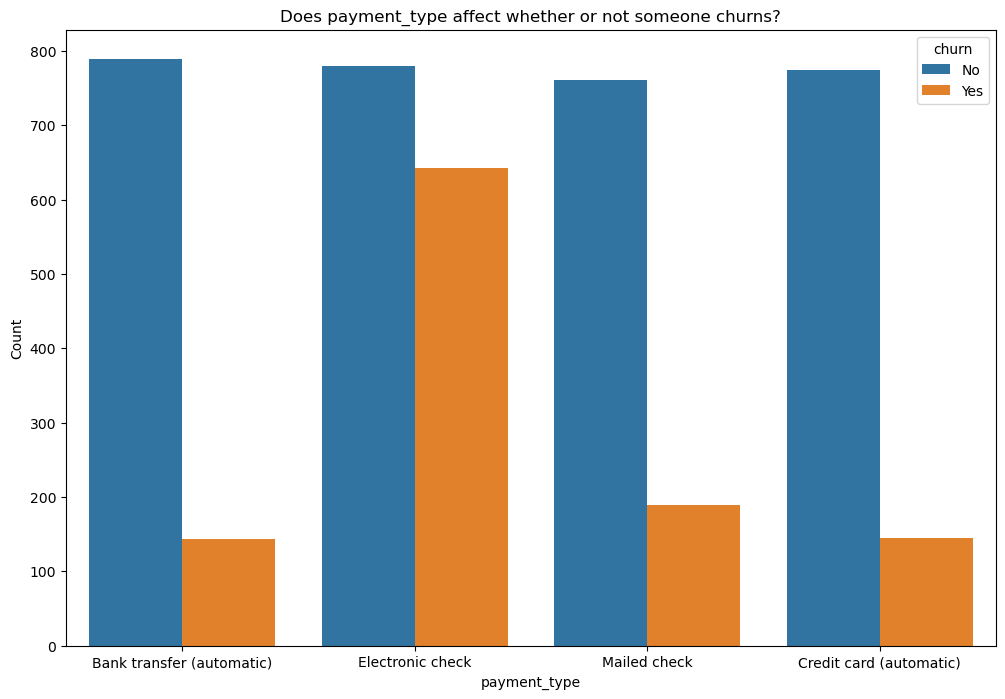

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x='payment_type', hue='churn', data=train)
plt.title('Does payment_type affect whether or not someone churns?')
plt.xlabel('payment_type')
plt.ylabel('Count')
plt.show()

* Electronic check payment type is 3 to 4 times higher than any other payment type that churns

* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (churn and payment_type) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.

* H0 = There is no relationship between churn and payment_type
* Ha = There is a relationship between churn and payment_type

In [11]:
# Create a contingency table of churn and payment_type
contingency_table = pd.crosstab(train['churn'], train['payment_type'])

# Print the contingency table
print(contingency_table)

# Perform a chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results of the chi-squared test
print('Chi-squared statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

payment_type  Bank transfer (automatic)  Credit card (automatic)  \
churn                                                              
No                                  789                      774   
Yes                                 144                      145   

payment_type  Electronic check  Mailed check  
churn                                         
No                         780           761  
Yes                        643           189  
Chi-squared statistic: 388.97403778913014
p-value: 5.412195802407718e-84
Degrees of freedom: 3
Expected frequencies: [[ 685.45136095  675.16591716 1045.44189349  697.9408284 ]
 [ 247.54863905  243.83408284  377.55810651  252.0591716 ]]


The p-value is much less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a rather good relationship between churn and payment_type. We will send it on to modeling.

## Does internet_service_type affect churn?

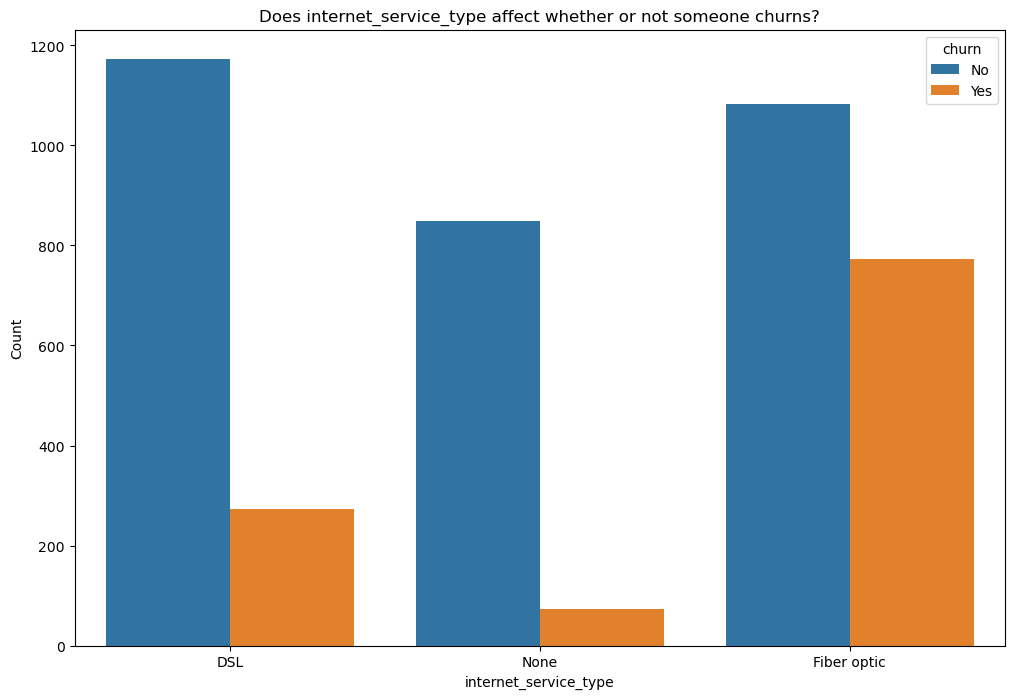

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x='internet_service_type', hue='churn', data=train)
plt.title('Does internet_service_type affect whether or not someone churns?')
plt.xlabel('internet_service_type')
plt.ylabel('Count')
plt.show()

* Fiber optic internet_service_type is about 3 times higher likely to churn than DSL and 2 times higher than DSL/none combined that churns

* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (churn and internet_service_type) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.

* H0 = There is no relationship between churn and internet_service_type
* Ha = There is a relationship between churn and internet_service_type

In [13]:
# Create a contingency table of churn and payment_type
contingency_table = pd.crosstab(train['churn'], train['internet_service_type'])

# Print the contingency table
print(contingency_table)

# Perform a chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results of the chi-squared test
print('Chi-squared statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

internet_service_type   DSL  Fiber optic  None
churn                                         
No                     1173         1082   849
Yes                     274          773    74
Chi-squared statistic: 423.25897064244805
p-value: 1.2316358365835844e-92
Degrees of freedom: 2
Expected frequencies: [[1063.07408284 1362.82130178  678.10461538]
 [ 383.92591716  492.17869822  244.89538462]]


The p-value is much less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a rather good relationship between churn and internet_service_type. We will send it on to modeling.

## Does contract_type affect churn?

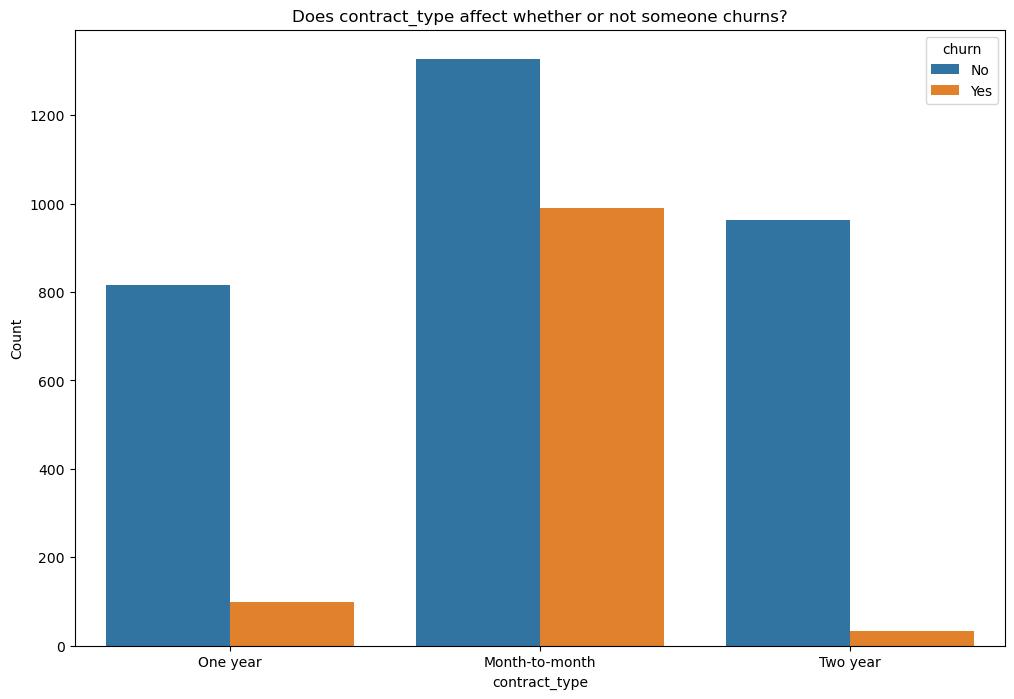

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x='contract_type', hue='churn', data=train)
plt.title('Does contract_type affect whether or not someone churns?')
plt.xlabel('contract_type')
plt.ylabel('Count')
plt.show()

* Month-to-Month contract_type is more than 8 times higher likely to churn than both annual contract types combined

* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (churn and contract_type) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.

* H0 = There is no relationship between churn and contract_type
* Ha = There is a relationship between churn and contract_type

In [15]:
# Create a contingency table of churn and payment_type
contingency_table = pd.crosstab(train['churn'], train['contract_type'])

# Print the contingency table
print(contingency_table)

# Perform a chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results of the chi-squared test
print('Chi-squared statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

contract_type  Month-to-month  One year  Two year
churn                                            
No                       1327       815       962
Yes                       990        98        33
Chi-squared statistic: 703.7870674341639
p-value: 1.4947896745220748e-153
Degrees of freedom: 2
Expected frequencies: [[1702.24094675  670.75786982  731.00118343]
 [ 614.75905325  242.24213018  263.99881657]]


The p-value is much less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a rather good relationship between churn

## Does whether or not a customer has tech_support affect churn?

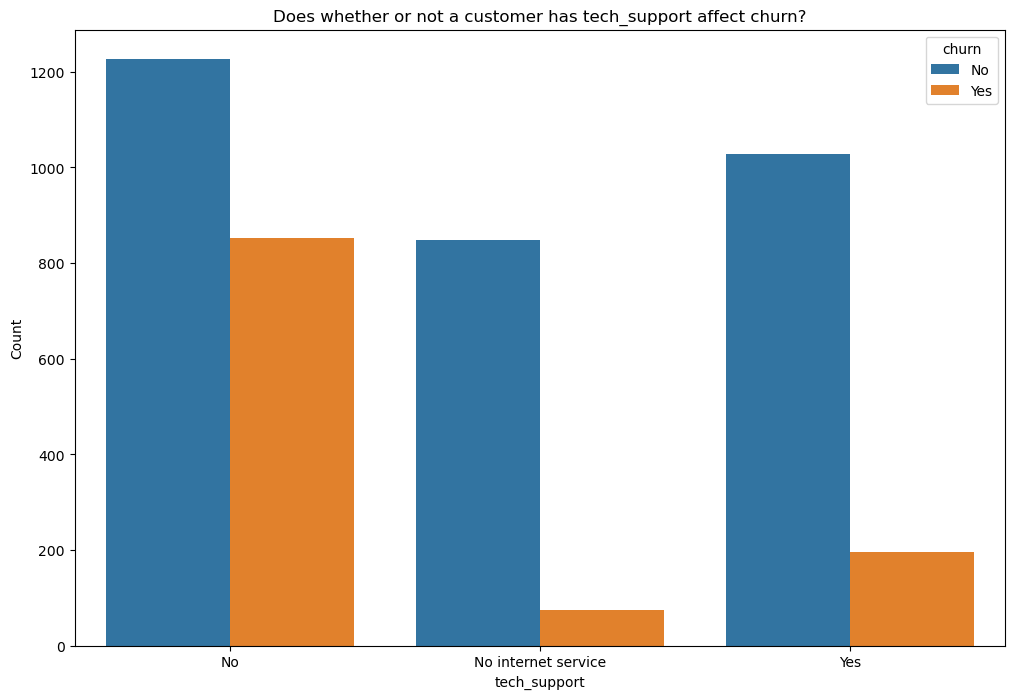

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(x='tech_support', hue='churn', data=train)
plt.title('Does whether or not a customer has tech_support affect churn?')
plt.xlabel('tech_support')
plt.ylabel('Count')
plt.show()

* Customers not having tech_support is approximately 4 times more likely to churn than customers who have tech_support

* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (churn and tech_support) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.

* H0 = There is no relationship between churn and tech_support
* Ha = There is a relationship between churn and tech_support

In [17]:
# Create a contingency table of churn and payment_type
contingency_table = pd.crosstab(train['churn'], train['tech_support'])

# Print the contingency table
print(contingency_table)

# Perform a chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results of the chi-squared test
print('Chi-squared statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

tech_support    No  No internet service   Yes
churn                                        
No            1227                  849  1028
Yes            852                   74   195
Chi-squared statistic: 455.32105998858174
p-value: 1.3436559397518597e-99
Degrees of freedom: 2
Expected frequencies: [[1527.38840237  678.10461538  898.50698225]
 [ 551.61159763  244.89538462  324.49301775]]


The p-value is much less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a rather good relationship between churn and tech_support. We will send it on to modeling.

## Does monthly_charges affect churn?

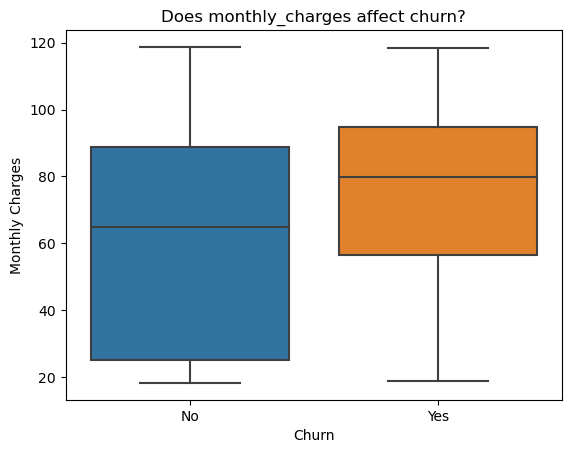

In [18]:
# Visualize the relationship between churn and monthly_charges
sns.boxplot(x='churn', y='monthly_charges', data=train)
plt.title('Does monthly_charges affect churn?')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

* Customers that churn have about a $15 higher mean than those who have not churned

* The two-sample t-test tests the null hypothesis that there is no difference between the means of the two groups (churn and non-churn customers) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant difference between the means of the two groups.

* H0 = There is no difference between monthly_charge price means for those who churned and did not churn
* Ha = There is a difference between monthly_charge price means for those who churned and did not churn

In [19]:
# Create separate dataframes for churn and non-churn customers
churn_df = train[train['churn'] == 'Yes']
non_churn_df = train[train['churn'] == 'No']

# Perform a two-sample t-test for the means of monthly charges
t_statistic, p_value = ttest_ind(churn_df['monthly_charges'], non_churn_df['monthly_charges'])

# Print the results of the t-test
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 12.470933594920117
P-value: 4.430821858383166e-35


The p-value is much less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a moderate difference between churn and monthly_charges. We will send it on to modeling.

## Exploration Summary
* payment_type has a strong relationship with churn with a p value of: 5.412195802407718e-84
* internet_service_type has a strong relationship with churn with a p value of: 1.2316358365835844e-92
* contract_type has a strong relationship with churn with a p value of: 1.4947896745220748e-153
* tech_support has a strong relationship with churn with a p value of: 1.3436559397518597e-99
* monthly_charges has a moderate relationship with churn with a p value of: 4.430821858383166e-35

## Features I will model
* payment_type
* internet_service_type
* contract_type
* tech_support
* monthly_charges

## Modeling

* The purpose of modeling the features I have selected is to find the most accurate model for predicting whether or not a customer will churn.

* The baseline accuracy we are trying to beat is 73% which is made up of the non-churn data. I will be using a Decision Tree, Random Forest, Logistic Regression, and KNearest models to try to find the best model. I will also be using a grid search to find the optimal hyperparameters with the highest accuracy scores.

In [20]:
train.churn.value_counts()

No     3104
Yes    1121
Name: churn, dtype: int64

In [21]:
#calculate baseline accuracy
baseline_accuracy = 3104 / (3104+1121)
baseline_accuracy

0.7346745562130178

## Prep Data for Modeling

In [22]:
# create X & y version of train/validate/test
# where X contains the features we want to use and y is a series with just the target variable

X_train = train.drop(columns=['churn', 'tech_support', 'contract_type', 'internet_service_type', 'payment_type'])
y_train = train.churn

X_validate = validate.drop(columns=['churn', 'tech_support', 'contract_type', 'internet_service_type', 'payment_type'])
y_validate = validate.churn

X_test = test.drop(columns=['churn', 'tech_support', 'contract_type', 'internet_service_type', 'payment_type'])
y_test = test.churn

In [23]:
X_train.head()

,monthly_charges,tech_support_no internet service,tech_support_yes,contract_type_one year,contract_type_two year,internet_service_type_fiber optic,internet_service_type_none,payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
5911,39.95,0,0,1,0,0,0,0,0,0
2479,26.90,1,0,1,0,0,1,0,1,0
5889,50.45,0,0,0,0,0,0,0,0,1
6087,60.05,0,1,0,1,0,0,0,0,0
785,87.55,0,0,1,0,1,0,1,0,0


## Decision Tree Classifier

In [24]:
dt = DecisionTreeClassifier()

# Define the hyperparameters to search
params = {'max_depth': [2, 4, 6, 8, 10],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 2, 3, 4, 5]}

# Create a grid search object
grid_search = GridSearchCV(dt, params, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a decision tree model with the best hyperparameters
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'],
                            min_samples_split=best_params['min_samples_split'],
                            min_samples_leaf=best_params['min_samples_leaf'])

# Fit the model on the training data
dt.fit(X_train, y_train)

# Predict the target variable for the training and validation data
y_train_pred = dt.predict(X_train)
y_validate_pred = dt.predict(X_validate)

# Calculate the accuracy of the model on the training and validation data
train_accuracy = accuracy_score(y_train, y_train_pred)
validate_accuracy = accuracy_score(y_validate, y_validate_pred)

# Print the accuracy of the model on the training and validation data
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', validate_accuracy)

Training Accuracy: 0.7742011834319527
Validation Accuracy: 0.7643718949609652


## Random Forest Classifier

In [25]:
# Create a random forest model
rf = RandomForestClassifier()

# Define the hyperparameters to search
params = {'n_estimators': [50, 100, 150, 200],
          'max_depth': [2, 4, 6, 8, 10],
          'min_samples_split': [2, 4, 6, 8, 10],
          'min_samples_leaf': [1, 2, 3, 4, 5]}

# Create a grid search object
grid_search = GridSearchCV(rf, params, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a random forest model with the best hyperparameters
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                            max_depth=best_params['max_depth'],
                            min_samples_split=best_params['min_samples_split'],
                            min_samples_leaf=best_params['min_samples_leaf'])

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict the target variable for the training and validation data
y_train_pred = rf.predict(X_train)
y_validate_pred = rf.predict(X_validate)

# Calculate the accuracy of the model on the training and validation data
train_accuracy = accuracy_score(y_train, y_train_pred)
validate_accuracy = accuracy_score(y_validate, y_validate_pred)

# Print the accuracy of the model on the training and validation data
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', validate_accuracy)

Training Accuracy: 0.7756213017751479
Validation Accuracy: 0.7693399574166075


## Logistics Regression

In [27]:
# Create a logistic regression model
lr = LogisticRegression()

# Define the hyperparameters to search
params = {'C': [0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}

# Create a grid search object
grid_search = GridSearchCV(lr, params, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a logistic regression model with the best hyperparameters
lr = LogisticRegression(C=best_params['C'],
                        penalty=best_params['penalty'])

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict the target variable for the training and validation data
y_train_pred = lr.predict(X_train)
y_validate_pred = lr.predict(X_validate)

# Calculate the accuracy of the model on the training and validation data
train_accuracy = accuracy_score(y_train, y_train_pred)
validate_accuracy = accuracy_score(y_validate, y_validate_pred)

# Print the accuracy of the model on the training and validation data
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', validate_accuracy)# Create a logistic regression model


Training Accuracy: 0.7746745562130177
Validation Accuracy: 0.7707594038325053


## KNN Model

In [28]:
# Create a KNN model
knn = KNeighborsClassifier()

# Define the hyperparameters to search
params = {'n_neighbors': [3, 5, 7, 9],
          'weights': ['uniform', 'distance'],
          'p': [1, 2]}

# Create a grid search object
grid_search = GridSearchCV(knn, params, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a KNN model with the best hyperparameters
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                           weights=best_params['weights'],
                           p=best_params['p'])

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the target variable for the training and validation data
y_train_pred = knn.predict(X_train)
y_validate_pred = knn.predict(X_validate)

# Calculate the accuracy of the model on the training and validation data
train_accuracy = accuracy_score(y_train, y_train_pred)
validate_accuracy = accuracy_score(y_validate, y_validate_pred)

# Print the accuracy of the model on the training and validation data
print('Training Accuracy:', train_accuracy)
print('Validation Accuracy:', validate_accuracy)

Training Accuracy: 0.8018934911242603
Validation Accuracy: 0.7579843860894251


## Comparing Models
* The Decision Tree Model yielded a train accuracy of 77.4 and a validate accuracy of 76.4
* The Random Forest Model yielded a train accuracy of 77.6 and a validate accuracy of 76.9
* The Logistics Regression Model yielded a train accuracy of 77.5 and a validate accuracy of 77.1
* The KNN Model yielded a train accuracy of 80.2 and a validate accuracy of 75.8

## Model Selection
* The Logistics Regression Model maintained over a 77% accuracy with only a 0.4 differential in both train and validate. Although, a small difference I feel the Logistics Regression Model is the highest accuracy average with a good consistency. We will move forward with a Logistic Regression Model using the final test data set.

In [29]:
# Logistic Regresstion (Best Model) Test

In [30]:
# Create a logistic regression model
lr = LogisticRegression()

# Define the hyperparameters to search
params = {'C': [0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}

# Create a grid search object
grid_search = GridSearchCV(lr, params, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a logistic regression model with the best hyperparameters
lr = LogisticRegression(C=best_params['C'],
                        penalty=best_params['penalty'])

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict the target variable for the test data
y_test_pred = lr.predict(X_test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy of the model on the test data
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.7856635911994322


## Modeling Summary
* The Logistics Regression Model maintained over a 77% accuracy with only a 0.4 differential in both train and validate. Although, a small difference I feel the Logistics Regression Model is the highest accuracy average with a good consistency. 
* In the end the Regression Model actually improved over the 77% in train and validate to a 78.6% accuracy in the test data. Based on the previous results, I feel 78.6% when compared to the 73.4% baseline is a small gain toward a viable prediction model.

## Conclusions
## Exploration
* The statistical modeling showed strong relationships between the target churn and the features payment_type, internet_service_type, contract_type, tech_support, and monthly_charges.
* Electronic check payment type is 3 to 4 times higher than any other payment type that churns
* Fiber optic internet_service_type is about 3 times higher likely to churn than DSL and 2 times higher than DSL/none combined that churns
* Month-to-Month contract_type is more than 8 times higher likely to churn than both annual contract types combined
* Customers not having tech_support is approximately 4 times more likely to churn than customers who have tech_support
* Customers that churn have about a $15 higher mean than those who have not churned
* All features were worthy of modeling.
## Modeling
* The final Logistic Regression Model on the test data set made a small improvement over the baseline of just over 5%
* It is possible that adding or dropping more features could add to the small improvement
## Recommendations
* Consider offering rebates for using automatic banking
* Consider a root cause of such a high churn for the flagship internet_service using fiber optic i.e. cost or maintenance downtime
* Consider better marketing the benefits of annual subscriptions
* Consider offering initial free trial service of tech support
* Consider rebates for higher tenure customers on monthly_charges
## Next Steps
* Cross-reference the profile services higher tenure customers prefer with the overall churn customers